In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

## connecting google drive to use dataset
#from google.colab import drive
#drive.mount('/content/drive')
#git change

#file_location = 'drive/MyDrive/fer2013/fer2013.csv'
file_location = 'fer2013.csv'
bres=48

In [2]:
# load data function is used to load data from the CSV file and return images and labels in the form of one hot encoded value


def load_data():
  # loading dataset as Dataframe
  dataset = pd.read_csv(file_location)
  images = []
  # converting each image data to float and reshaping it to 48 x 48
  for img in dataset.pixels:
    reshapedImage = np.fromstring(img, dtype=float, sep=' ').reshape(bres, bres)
    # append all images
    images.append(reshapedImage);

  # converting labels to one hot encoded values of float32
  emotions = pd.get_dummies(dataset.emotion).values.astype('float32')
  # return processed images and emotions
  return images, emotions

images, emotions = load_data()

In [3]:
# Splitting data into train, test and validation
X_train, X_rem, y_train, y_rem = train_test_split(images, emotions, train_size=0.8, shuffle=True)

# Splitting remaining data in half as validation and test data
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, shuffle=True)

# this function is used to change the data mean to 0 and standard deviation to 1
def standarize_data(data):
    # convert data to float32
    data = np.array(data, 'float32')
    # subtract mean from the data
    data -= np.mean(data, axis=0)
    # dividing the data with standard deviation
    data /= np.std(data, axis=0)
    return data

# standardizing all data
X_train = standarize_data(X_train)
X_test = standarize_data(X_test)
X_valid = standarize_data(X_valid)

In [4]:
# reshaping data into image
X_train = X_train.reshape(X_train.shape[0], bres,bres,1)
X_test = X_test.reshape(X_test.shape[0],    bres, bres,1)
X_valid = X_valid.reshape(X_valid.shape[0], bres, bres,1)

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

In [6]:
#parameters for number of training epochs and path to store and load the notebook
epochs = 70
path = './'

In [7]:
# it is used to generate image using ImageDataGenerator
# It rotates the image in 20 degree range, shift the width and height, flip the image horizontally, and zoom the image
image_augmentation = ImageDataGenerator(
                        rotation_range=20,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        horizontal_flip=True,
                        featurewise_std_normalization=False,
                        zoom_range=.2
                        )

# Model structure

In [8]:
# Defining model Structure
model = Sequential()

# Each block contain same type of layers, the only difference being the filter in Conv2D layer
# Block 1
# Input layer with input shape of 48 x 48 x 1 and 32 filters
model.add(Conv2D(32,(3,3),padding='same' ,input_shape=(bres, bres,1), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Block 2
model.add(Conv2D(64,(3,3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Block 3
model.add(Conv2D(128,(3,3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Block 4
model.add(Conv2D(256,(3,3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Dense Network
# the data from the previous layer is flattened and is passed to Dense layer
model.add(Flatten())
# Dense layer with 256 neurons
model.add(Dense(256, activation='relu'))
# Dense layer with 128 neurons
model.add(Dense(128, activation='relu'))
# Dense layer with 64 neurons
model.add(Dense(64, activation='relu'))

# Output layer that returns probability distribution
model.add(Dense(7, activation='softmax'))

In [9]:
# defining loss function, optimizer, and metrics
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
# displaying the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                        

In [10]:
#callbacks
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
log_file_path = path + 'emotion.log'

# Logging the model output in a log file and storing it in Drive
csv_logger = CSVLogger(log_file_path, append=False)

# Stopping the model if the validation loss does not increase over during 5 epochs
early_stop = EarlyStopping(monitor='val_loss',
                          patience=5,
                          verbose=1,
                          restore_best_weights=True)

# Store the values of model during training so it can be loaded in the model
checkpoint = ModelCheckpoint(path + 'emotion.ckpt',
                             save_weights_only=True,
                             verbose=1)

callbacks = [csv_logger, early_stop, checkpoint]

# Model training

In [11]:
# Training the model using augmented data created with Training data
m = model.fit(image_augmentation.flow(X_train, y_train, 64), 
                    # data for validation
                    validation_data = (X_valid, y_valid),
                    # shuffling the data
                    shuffle = True,
                    # display the training process and the data
                    verbose = 1,
                    # number of rounds to train
                    epochs = epochs, 
                    steps_per_epoch = len(X_train)/64,
                    callbacks = callbacks)

Epoch 1/70
449/448 [==============================] - ETA: 0s - loss: 1.7695 - accuracy: 0.2761
Epoch 1: saving model to .\emotion.ckpt
448/448 [==============================] - 109s 241ms/step - loss: 1.7695 - accuracy: 0.2761 - val_loss: 1.6580 - val_accuracy: 0.3603
Epoch 2/70
449/448 [==============================] - ETA: 0s - loss: 1.5308 - accuracy: 0.3975
Epoch 2: saving model to .\emotion.ckpt
448/448 [==============================] - 100s 223ms/step - loss: 1.5308 - accuracy: 0.3975 - val_loss: 1.3615 - val_accuracy: 0.4954
Epoch 3/70
449/448 [==============================] - ETA: 0s - loss: 1.3645 - accuracy: 0.4725
Epoch 3: saving model to .\emotion.ckpt
448/448 [==============================] - 101s 224ms/step - loss: 1.3645 - accuracy: 0.4725 - val_loss: 1.2509 - val_accuracy: 0.5263
Epoch 4/70
449/448 [==============================] - ETA: 0s - loss: 1.2812 - accuracy: 0.5071
Epoch 4: saving model to .\emotion.ckpt
448/448 [==============================] - 101s 226

In [12]:
# Evaluate model with test data
model.evaluate(X_test, y_test)

113/113 [==============================] - 3s 26ms/step - loss: 0.9530 - accuracy: 0.6425


[0.9529686570167542, 0.6425188183784485]

In [13]:
# Saving model using in drive
model.save('./emotion_'+str(bres)+'.hdf5')

# Data visualization

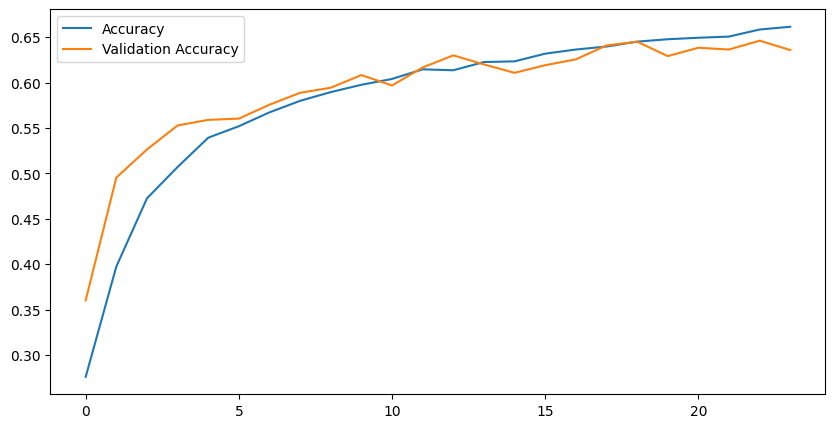

In [14]:
# Read the log file from the drive
log = pd.read_csv('./emotion.log')

# Plotting the figure of accuracy and validation accuracy over epoch
plt.figure(figsize=(10,5))
# Plot the data from the model
plt.plot(m.history['accuracy'], label='Accuracy')
plt.plot(m.history['val_accuracy'], label='Validation Accuracy')
plt.legend()

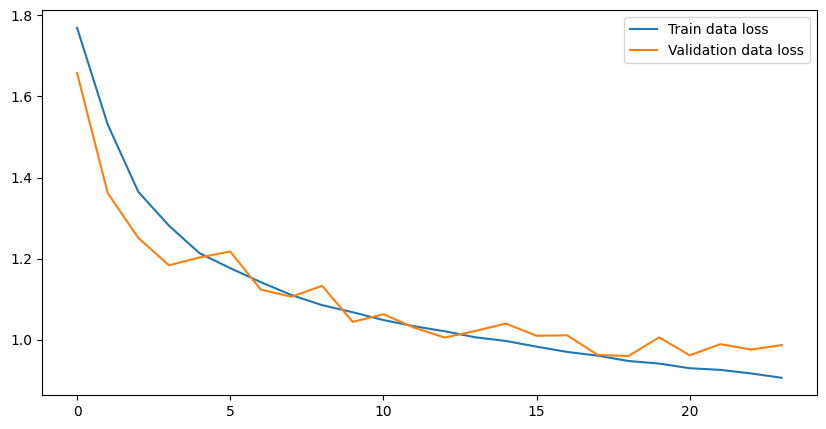

In [15]:
# Plot of Training data loss and Validation data loss
plt.figure(figsize=(10,5))
plt.plot(m.history['loss'], label='Train data loss')
plt.plot(m.history['val_loss'], label='Validation data loss')
plt.legend()

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Predicting the test data
test_data_prediction = model.predict(X_test).argmax(axis=1)

# converting the one hot encoded labels to single value labels
label_x_test = np.array(y_test)
label_x_test = np.where(label_x_test)[1]

113/113 [==============================] - 3s 26ms/step


<AxesSubplot:>

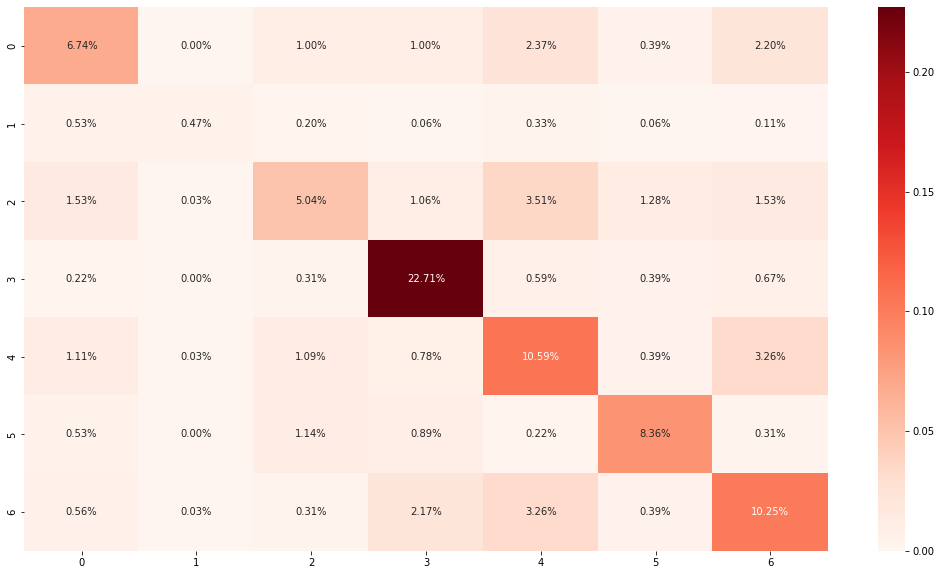

In [41]:
# Get values of confusion matrix using the confusion_matrix function from sklearn.metrics
confusion_matrix_values = confusion_matrix(label_x_test, test_data_prediction)
plt.figure(figsize = (18,10))
# generate a heatmap using seaborn and display the data in terms of percentage
sns.heatmap(confusion_matrix_values/np.sum(confusion_matrix_values), 
            annot=True, fmt='0.2%', cmap='Reds')

<AxesSubplot:xlabel='emotion', ylabel='count'>

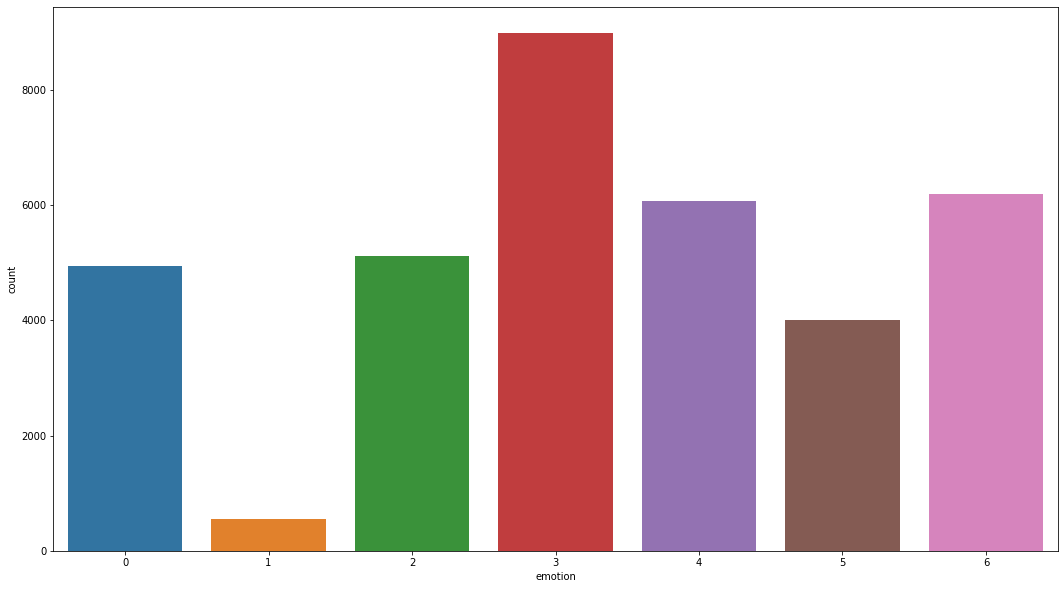

In [42]:

# Count Plot
# Displays the number of data in each labels
plt.figure(figsize = (18,10))
dataset = pd.read_csv(file_location)
# Plot using countplot
sns.countplot(x='emotion', data = dataset)
# 'Disgust' has the lowest number of data whereas 'Happy' has the highest

# Prediction

In [52]:
# defining emotions
expressions = ["angry","disgust","scared", "happy", "sad", "surprised","neutral"]


import tensorflow as tf 
new_model = tf.keras.models.load_model('./emotion.hdf5')

# Check its architecture
#new_model.summary()
model = new_model
# Function to predict test data and display the image including the actual and model predicted values
def predict(val):
  # reshaping the test data to array of image
  img = X_test[val].reshape(1,bres,bres,1)
  print(type(img))
  # plot the image in graph
  plt.imshow(X_test[val].reshape(bres, bres) ,cmap='gray')
  plt.show()
  # display the actual and predicted values
  print("Actual : ", expressions[np.argmax(y_test[val])])
  print("Predicted: ",expressions[np.argmax(model.predict(img)[0])])

<class 'numpy.ndarray'>


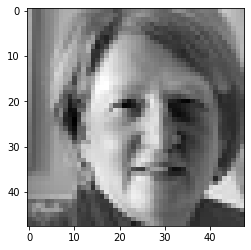

Actual :  happy
1/1 [==============================] - 1s 522ms/step
Predicted:  happy


In [44]:
val = 3
l = [val]#,4,5,10,23]
for i in l:
    predict(i)

In [45]:
img = X_test[val].reshape(1,bres, bres,1)

type(X_test[val]), img

(numpy.ndarray,
 array([[[[ 0.7174069 ],
          [-0.45749372],
          [-0.569327  ],
          ...,
          [ 0.99563533],
          [ 0.8678198 ],
          [ 0.73657936]],
 
         [[ 0.69439596],
          [-0.4635281 ],
          [-0.56101096],
          ...,
          [ 0.9833125 ],
          [ 0.8628085 ],
          [ 0.78767735]],
 
         [[ 0.73695916],
          [-0.45158446],
          [-0.5350939 ],
          ...,
          [ 0.9942369 ],
          [ 0.87099487],
          [ 0.8377125 ]],
 
         ...,
 
         [[-0.5273571 ],
          [-0.19212477],
          [-0.54684186],
          ...,
          [-1.1174161 ],
          [-1.1849875 ],
          [-1.3397397 ]],
 
         [[-0.9298442 ],
          [-0.6942244 ],
          [-0.4167274 ],
          ...,
          [-1.2674592 ],
          [-1.1206542 ],
          [-1.1174344 ]],
 
         [[-0.9632199 ],
          [-1.0732679 ],
          [-0.8662232 ],
          ...,
          [-1.2524253 ],
          [-1

In [46]:
from PIL import Image
import cv2

file = ".//img//IMG-3731.jpg"

def predictimg(fname, flg=1):
    img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
    #cv2.imshow('orig',img)
    img4 = cv2.resize(img, (bres,bres))
    #type(img4)
    img4=img4.reshape(1,bres, bres,1)
    prediction = expressions[np.argmax(model.predict(img4)[0])]
    if flg & 2:
        plt.imshow(img4.reshape(bres, bres) ,cmap='gray')
        plt.show()
    if flg & 1:
        print('file {0} prediction is {1}'.format(fname, prediction))
    return prediction

predictimg(file)


1/1 [==============================] - 0s 326ms/step
file .//img//IMG-3731.jpg prediction is sad


'sad'

1/1 [==============================] - 0s 51ms/step


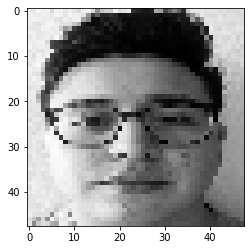

file .//img//michael-1.png prediction is surprised


'surprised'

In [47]:
predictimg(".//img//michael-1.png", 3)



1/1 [==============================] - 0s 39ms/step


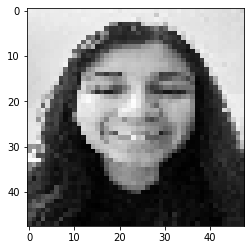

file .//img//IMG-3721.jpg prediction is sad
1/1 [==============================] - 0s 316ms/step


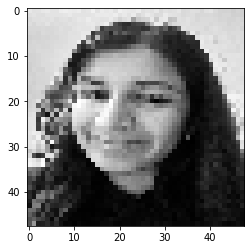

file .//img//IMG-3722.jpg prediction is sad
1/1 [==============================] - 0s 43ms/step


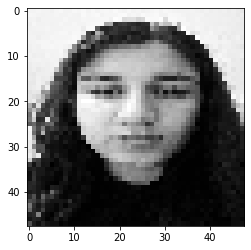

file .//img//IMG-3723.jpg prediction is sad
1/1 [==============================] - 0s 63ms/step


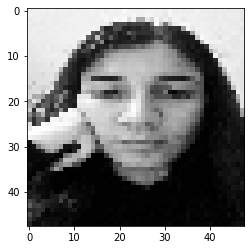

file .//img//IMG-3724.jpg prediction is sad
1/1 [==============================] - 0s 53ms/step


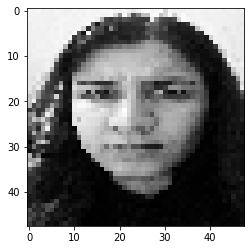

file .//img//IMG-3725.jpg prediction is sad
1/1 [==============================] - 0s 49ms/step


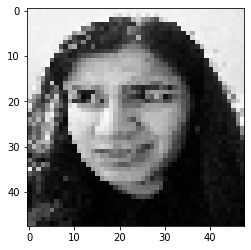

file .//img//IMG-3726.jpg prediction is sad
1/1 [==============================] - 0s 38ms/step


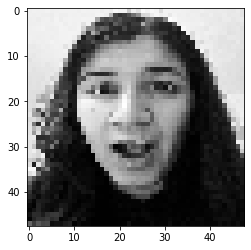

file .//img//IMG-3727.jpg prediction is sad
1/1 [==============================] - 0s 38ms/step


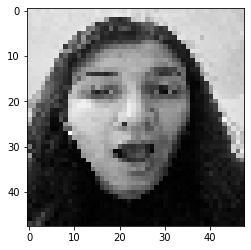

file .//img//IMG-3728.jpg prediction is sad
1/1 [==============================] - 0s 44ms/step


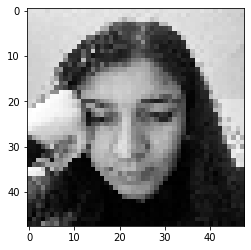

file .//img//IMG-3729.jpg prediction is surprised
1/1 [==============================] - 0s 42ms/step


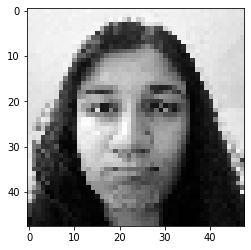

file .//img//IMG-3731.jpg prediction is sad
1/1 [==============================] - 0s 38ms/step


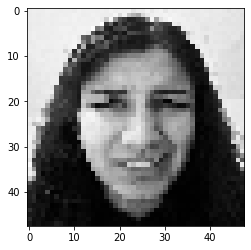

file .//img//IMG-3734.jpg prediction is sad
1/1 [==============================] - 0s 37ms/step


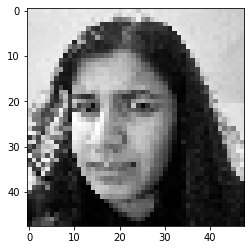

file .//img//IMG-3735.jpg prediction is sad
1/1 [==============================] - 0s 49ms/step


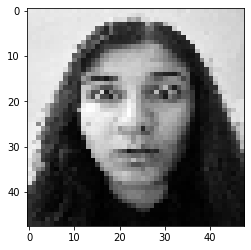

file .//img//IMG-3738.jpg prediction is sad
1/1 [==============================] - 0s 53ms/step


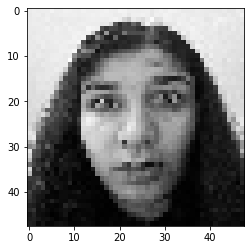

file .//img//IMG-3743.jpg prediction is sad


In [48]:
imglst = ['IMG-3721.jpg', 'IMG-3722.jpg', 'IMG-3723.jpg', 'IMG-3724.jpg', 
'IMG-3725.jpg', 'IMG-3726.jpg', 'IMG-3727.jpg', 'IMG-3728.jpg', 
'IMG-3729.jpg', 'IMG-3731.jpg', 'IMG-3734.jpg', 'IMG-3735.jpg', 
'IMG-3738.jpg', 'IMG-3743.jpg']

for i in imglst:
    predictimg(".//img//"+i, 3)

1/1 [==============================] - 0s 51ms/step


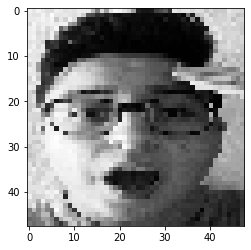

file .//img//IMG_5124.png prediction is surprised
1/1 [==============================] - 0s 47ms/step


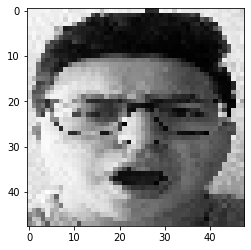

file .//img//IMG_5125.png prediction is surprised
1/1 [==============================] - 0s 36ms/step


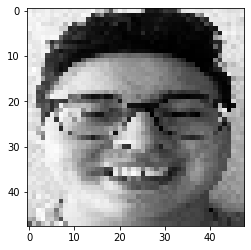

file .//img//IMG_5126.png prediction is surprised
1/1 [==============================] - 0s 48ms/step


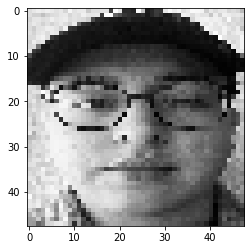

file .//img//IMG_5127.png prediction is scared
1/1 [==============================] - 0s 37ms/step


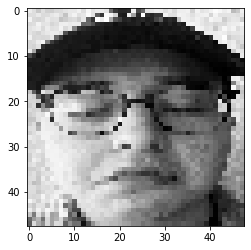

file .//img//IMG_5128.png prediction is surprised
1/1 [==============================] - 0s 40ms/step


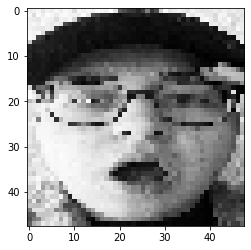

file .//img//IMG_5129.png prediction is sad
1/1 [==============================] - 0s 36ms/step


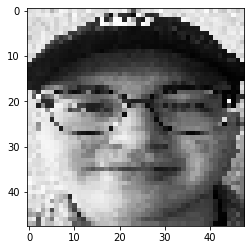

file .//img//IMG_5130.png prediction is surprised
1/1 [==============================] - 0s 39ms/step


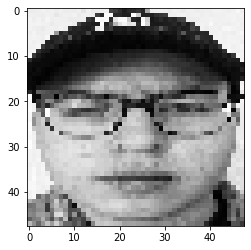

file .//img//IMG_5131.png prediction is surprised
1/1 [==============================] - 0s 36ms/step


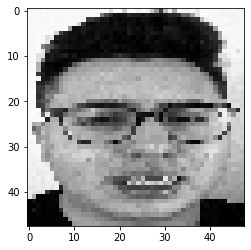

file .//img//IMG_5132.png prediction is surprised
1/1 [==============================] - 0s 35ms/step


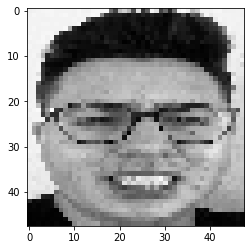

file .//img//IMG_5133.png prediction is surprised
1/1 [==============================] - 0s 46ms/step


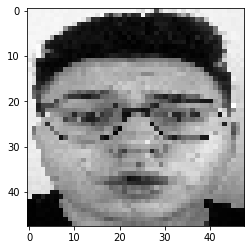

file .//img//IMG_5134.png prediction is surprised


In [49]:
imglst = ['IMG_5124.png', 'IMG_5125.png', 'IMG_5126.png',
'IMG_5127.png', 'IMG_5128.png', 'IMG_5129.png',
'IMG_5130.png', 'IMG_5131.png', 'IMG_5132.png',
'IMG_5133.png', 'IMG_5134.png',]
for i in imglst:
    predictimg(".//img//"+i, 3)


In [50]:

def predictimg2(fname, flg=1):
    img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
    #cv2.imshow('orig',img)
    img4 = cv2.resize(img, (bres,bres))
    #type(img4)
    img4=img4.reshape(1,bres, bres,1)
    prediction = expressions[np.argmax(model.predict(img4)[0])]
    if flg & 2:
        plt.imshow(img4.reshape(bres, bres) ,cmap='gray')
        plt.show()
    if flg & 1:
        print('file {0} prediction is {1}'.format(fname, prediction))
    return prediction

1/1 [==============================] - 0s 38ms/step


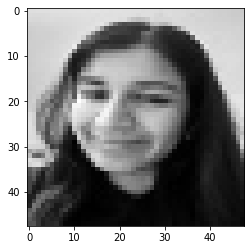

file .//img//ni_happy_down_48x48.jpg prediction is sad


In [51]:
imglst = ['ni_happy_down_48x48.jpg']

for i in imglst:
    predictimg2(".//img//"+i, 3)